In [46]:
##########################################################################
######################PRETRAINED RESNET AND LSTM########################
##########################################################################

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import random
import numpy as np
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# Defining Model

In [47]:
class ImageEncoder(nn.Module):
    def __init__(self, embedding_dim, trainable_layers=0):
        super(ImageEncoder, self).__init__()
        base_model = models.efficientnet_b3(pretrained=True)
        for param in base_model.parameters():
            param.requires_grad = False
        if trainable_layers > 0:
            feature_params = list(base_model.features.parameters())
            for param in feature_params[-trainable_layers:]:
                param.requires_grad = True
        self.feature_extractor = base_model.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1536, embedding_dim)

    def forward(self, images):
        x = self.feature_extractor(images)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        embeddings = self.fc(x)
        return embeddings

class CaptionDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, vocab, num_layers=1):
        super(CaptionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_state = (torch.zeros(1, 1, hidden_dim), torch.zeros(1, 1, hidden_dim))
        self.end_token_id = vocab(vocab.end_word)  # Add the end token ID
        self.vocab = vocab
        self.start_token_id = vocab(vocab.start_word)

    def forward(self, image_features, captions):
        caption_embeddings = self.word_embeddings(captions[:, :-1])
        inputs = torch.cat((image_features.unsqueeze(1), caption_embeddings), dim=1)
        lstm_output, self.hidden_state = self.lstm(inputs)
        outputs = self.fc(lstm_output)
        return outputs
    
    def generate_caption(self, image_features, beam_size=3, max_length=20):
        device = image_features.device
        vocab_size = self.fc.out_features
        assert image_features.size(0) == 1, "Batch size should be 1 for inference."
        start_token_id = self.start_token_id
        end_token_id = self.end_token_id
        h = torch.zeros(self.lstm.num_layers, beam_size, self.hidden_dim, device=device)
        c = torch.zeros(self.lstm.num_layers, beam_size, self.hidden_dim, device=device)
        seqs = torch.LongTensor([[start_token_id]]).to(device)
        seqs = seqs.repeat(beam_size, 1)
        top_k_scores = torch.zeros(beam_size, 1, device=device)
        image_features = image_features.repeat(beam_size, 1)
        image_features = image_features.unsqueeze(1)
        with torch.no_grad():
            lstm_output, (h, c) = self.lstm(image_features, (h, c))
        complete_seqs = []
        complete_seqs_scores = []
        for step in range(max_length):
            last_word_ids = seqs[:, -1]
            embeddings = self.word_embeddings(last_word_ids)
            embeddings = embeddings.unsqueeze(1)
            lstm_output, (h, c) = self.lstm(embeddings, (h, c))
            scores = self.fc(lstm_output.squeeze(1))
            scores = F.log_softmax(scores, dim=1)
            scores = top_k_scores.expand_as(scores) + scores
            top_k_scores_flat, top_k_words_flat = scores.view(-1).topk(beam_size, dim=0, largest=True, sorted=True)
            prev_word_inds = top_k_words_flat // vocab_size
            next_word_inds = top_k_words_flat % vocab_size
            new_seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)
            new_scores = top_k_scores_flat
            complete_inds = (next_word_inds == end_token_id).nonzero(as_tuple=False).squeeze(1)
            incomplete_inds = (next_word_inds != end_token_id).nonzero(as_tuple=False).squeeze(1)
            if len(complete_inds) > 0:
                for i in complete_inds:
                    complete_seqs.append(new_seqs[i].tolist())
                    complete_seqs_scores.append(new_scores[i].item())
            k = beam_size - len(complete_seqs)
            if k <= 0:
                break
            seqs = new_seqs[incomplete_inds]
            top_k_scores = new_scores[incomplete_inds].unsqueeze(1)

            h = h[:, prev_word_inds[incomplete_inds], :]
            c = c[:, prev_word_inds[incomplete_inds], :]

        if len(complete_seqs_scores) == 0:
            complete_seqs = seqs.tolist()
            complete_seqs_scores = top_k_scores.squeeze(1).tolist()


        best_idx = complete_seqs_scores.index(max(complete_seqs_scores))
        best_seq = complete_seqs[best_idx]

        words = [self.vocab.idx2word[idx] for idx in best_seq]
        # Remove the <end> token if it exists
        if end_token_id in best_seq:
            words = words[:best_seq.index(end_token_id)]

        return words


# Getting the data ready

In [ ]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import transforms
from data_loader import get_data_loader
import torch.optim as optim
from vocabulary import Vocabulary
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu
from pycocotools.coco import COCO
import nltk

vocab = Vocabulary(annotations_file='../../coco_dataset/annotations/captions_train2017.json', vocab_exists=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Vocabulary successfully loaded from vocab.pkl file!


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
#  training
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#
images_dir = '../../coco_dataset/train2017'
captions_path = '../../coco_dataset/annotations/captions_train2017.json'

dataloader = get_data_loader(
    images_dir=images_dir,
    captions_path=captions_path,
    vocab_exists=False,
    batch_size=128,
    transform=transform
)

embedding_dim = 256
hidden_dim = 512
vocab_size = len(vocab)
encoder = ImageEncoder(embedding_dim).to(device)
decoder = CaptionDecoder(embedding_dim, hidden_dim, vocab_size, vocab).to(device)

criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)
params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
encoder_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
decoder_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
Building vocabulary...
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
Vocabulary successfully built and saved to vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:30<00:00, 19329.58it/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training loop

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        images = batch['images'].to(device)
        captions = batch['tokenized_caption'].to(device)

        encoder.zero_grad()
        decoder.zero_grad()

        image_features = encoder(images)
        outputs = decoder(image_features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    encoder_scheduler.step()
    decoder_scheduler.step()

CaptionDecoder(
  (word_embeddings): Embedding(13398, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=13398, bias=True)
)

In [ ]:
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

# Evaluating the Model

In [49]:
####################################################################################################
#Evaluating the model
####################################################################################################

vocab = Vocabulary(annotations_file='../../coco_dataset/annotations/captions_train2017.json', vocab_exists=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = ImageEncoder(embedding_dim).to(device)
decoder = CaptionDecoder(embedding_dim, hidden_dim, vocab_size, vocab).to(device)

Vocabulary successfully loaded from vocab.pkl file!


In [50]:
print(len(vocab))

13398


In [51]:
encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

encoder.eval()
decoder.eval()

CaptionDecoder(
  (word_embeddings): Embedding(13398, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=13398, bias=True)
)

# Bleu score function

In [35]:
from collections import Counter
import math

def compute_bleu(reference_corpus, candidate_corpus, max_n=4, smoothing=True):
    """
    Compute BLEU score for a candidate corpus against a reference corpus.

    Args:
        reference_corpus (list of list of str): List of references (each a tokenized list of words).
        candidate_corpus (list of list of str): List of candidates (each a tokenized list of words).
        max_n (int): Maximum n-gram order to use.
        smoothing (bool): Apply smoothing to prevent zero scores for missing n-grams.

    Returns:
        float: The BLEU score.
    """
    def ngram_counts(tokens, n):
        """Generate n-gram counts for a list of tokens."""
        return Counter(tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1))

    hypotheses = []
    references = []
    for img_id in set(reference_corpus.keys()).intersection(set(candidate_corpus.keys())):
        img_refs = [cap.split() for cap in reference_corpus[img_id]]
        references.append(img_refs)
        hypotheses.append(candidate_corpus[img_id][0].strip().split())
    
    clipped_counts = Counter()
    total_counts = Counter()
    reference_lengths = []
    candidate_lengths = []

    for references, candidate in zip(references, hypotheses):
        candidate_lengths.append(len(candidate))
        reference_lengths.append(min(len(ref) for ref in references))

        for n in range(1, max_n + 1):
            candidate_ngrams = ngram_counts(candidate, n)
            reference_ngrams = Counter()
            for ref in references:
                reference_ngrams |= ngram_counts(ref, n)

            # Clip counts to reference max counts
            for ngram, count in candidate_ngrams.items():
                clipped_counts[ngram] += min(count, reference_ngrams[ngram])
            total_counts[n] += sum(candidate_ngrams.values())

    # Calculate precision for each n-gram order
    precisions = []
    for n in range(1, max_n + 1):
        if total_counts[n] == 0:
            precisions.append(0)
        else:
            precisions.append(clipped_counts[n] / total_counts[n])

    # Smoothing: Replace 0 precision with a very small value to avoid log(0)
    if smoothing:
        precisions = [p if p > 0 else 1e-9 for p in precisions]

    # Geometric mean of precisions
    geometric_mean = math.exp(sum(math.log(p) for p in precisions) / max_n)

    # Brevity penalty
    ref_length = sum(reference_lengths)
    cand_length = sum(candidate_lengths)
    brevity_penalty = math.exp(1 - ref_length / cand_length) if cand_length < ref_length else 1

    return brevity_penalty * geometric_mean

# Evaluate function

In [59]:
import sacrebleu

#beam search generate caption
def evaluate_model(dataloader, max_length=20):
    true_sentences = {}
    predicted_sentences = {}

    for batch in tqdm(dataloader, desc='Evaluating', unit='batch'):
        images = batch['images'].to(device)
        captions = batch['all_captions']
        image_ids = batch['image_ids']

        for i, img_id in enumerate(image_ids):
            true_sentences[img_id] = captions[i]

        with torch.no_grad():
            image_features = encoder(images)  # Assuming batch_size=1
            generated_words = decoder.generate_caption(image_features, beam_size=3, max_length=max_length)
            generated_caption = ' '.join(generated_words)
            for i, img_id in enumerate(image_ids):
                predicted_sentences[img_id] = [generated_caption]

    avg_bleu_score = bleu_score(true_sentences, predicted_sentences)
    return avg_bleu_score


def bleu_score(true_sentences, predicted_sentences):
    hypotheses = []
    references = []
    for img_id in set(true_sentences.keys()).intersection(set(predicted_sentences.keys())):
        img_refs = [cap.split() for cap in true_sentences[img_id]]
        references.append(img_refs)
        hypotheses.append(predicted_sentences[img_id][0].strip().split())

    return corpus_bleu(references, hypotheses)

In [61]:
images_dir = '../../coco_dataset/val2017'
captions_path = '../../coco_dataset/annotations/captions_val2017.json'
dataloader = get_data_loader(images_dir, captions_path, vocab_exists=True, batch_size=1, transform=transform)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 25014/25014 [00:01<00:00, 17008.34it/s]


In [62]:
avg_bleu_score = evaluate_model(dataloader)
print(f"Average BLEU Score: {avg_bleu_score}")

Evaluating: 100%|██████████| 5000/5000 [02:09<00:00, 38.61batch/s]


TypeError: Fraction.__new__() got an unexpected keyword argument '_normalize'

In [63]:
import sacrebleu

def evaluate_model(dataloader, max_length=20):
	true_sentences = {}
	predicted_sentences = {}

	for batch in tqdm(dataloader, desc='Evaluating', unit='batch'):
		images = batch['images'].to(device)
		captions = batch['all_captions']
		image_ids = batch['image_ids']

		for i, img_id in enumerate(image_ids):
			true_sentences[img_id] = captions[i]
			
		with torch.no_grad():
			image_features = encoder(images)  # Assuming batch_size=1
			generated_words = decoder.generate_caption(image_features, beam_size=3, max_length=max_length)
			generated_caption = ' '.join(generated_words)
			for i, img_id in enumerate(image_ids):
				predicted_sentences[img_id] = [generated_caption]

	avg_bleu_score = bleu_score(true_sentences, predicted_sentences)
	return avg_bleu_score

def bleu_score(true_sentences, predicted_sentences):
    hypotheses = []
    references = []
    for img_id in set(true_sentences.keys()).intersection(set(predicted_sentences.keys())):
        img_refs = [cap.split() for cap in true_sentences[img_id]]
        references.append(img_refs)
        hypotheses.append(predicted_sentences[img_id][0].strip().split())

    return sacrebleu.corpus_bleu(references, hypotheses)

In [64]:
images_dir = '../../coco_dataset/val2017'
captions_path = '../../coco_dataset/annotations/captions_val2017.json'
dataloader = get_data_loader(images_dir, captions_path, vocab_exists=True, batch_size=1, transform=transform)

avg_bleu_score = evaluate_model(dataloader)
print(f"Average BLEU Score: {avg_bleu_score}")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


Evaluating: 100%|██████████| 5000/5000 [02:08<00:00, 38.97batch/s]


TypeError: BLEU: Each element of `hyps` should be a string.

# Testing images

In [ ]:
transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [33]:
def generate_caption(image, max_length=200):
    image = transform_test(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = encoder(image)
    generated_caption = decoder.generate_caption(image_features, max_length=max_length)
    return generated_caption

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def generate_and_display_caption(image, max_length=20):
    """
    Generate a caption for a given image and display the image.
    Args:
        image: PIL image or NumPy array of the image to caption.
        encoder: Trained ImageEncoder model.
        decoder: Trained CaptionDecoder model.
        vocab: Vocabulary object.
        transform: Transformation to apply to the image.
        device: Device to use (CPU or GPU).
        max_length: Maximum length of the generated caption.
    """
    
    image_tensor = transform_test(image).unsqueeze(0).to(device)

    # Generate the caption
    with torch.no_grad():
        image_features = encoder(image_tensor)
    generated_ids = decoder.generate_caption(image_features, max_length=max_length)
    # concatenate the generated words
    generated_caption = ' '.join(generated_ids)
    
    # Display the image
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.title("Generated Caption: " + generated_caption)
    plt.show()

    # Print the caption
    print(f"Generated Caption: {generated_caption}")


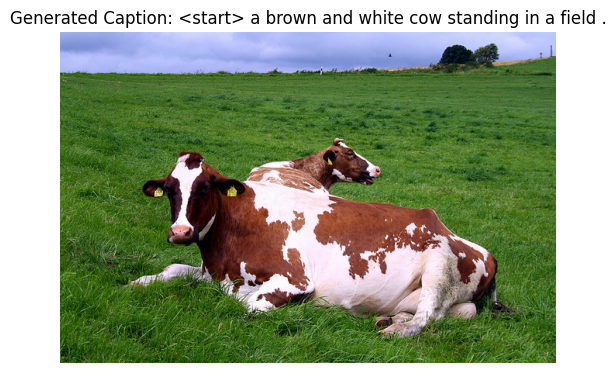

Generated Caption: <start> a brown and white cow standing in a field .


In [45]:
# Load the image
image_path = "../../coco_dataset/test2017/000000000019.jpg"
image = Image.open(image_path).convert("RGB")

# Generate and display the caption
generate_and_display_caption(image, max_length=20)
